In [2]:
import cv2
import numpy as np
import mediapipe as mp
import time
import os
from matplotlib import pyplot as plt

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [6]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        
        draw_styled_landmarks(image, results)

        cv2.imshow("Camera Feed", image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [8]:
results

mediapipe.python.solution_base.SolutionOutputs

In [9]:
draw_styled_landmarks(frame, results)

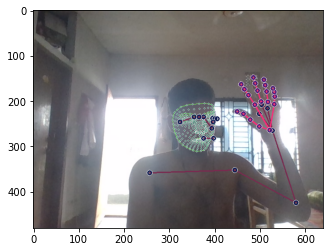

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [11]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [12]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
extract_keypoints(results)

array([ 0.61570227,  0.54305345, -0.55336356, ...,  0.        ,
        0.        ,  0.        ])

In [15]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(["hello", "thanks", "i love you"])
no_sequences = 30
sequence_length = 30

In [16]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [ ]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
        
                ret, frame = cap.read()

                image, results = mediapipe_detection(frame, holistic)

                draw_styled_landmarks(image, results)
                
                if frame_num == 0:
                    cv2.putText(image, "Starting Collection", (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, "Collecting Frame for {} video number {}".format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, "Collecting Frame for {} video number {}".format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                cv2.imshow("Camera Feed", image)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [22]:
label_map = {label:num for num, label in enumerate(actions)}

In [23]:
label_map

{'hello': 0, 'thanks': 1, 'i love you': 2}

In [24]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [25]:
X = np.array(sequences)

In [26]:
X.shape

(90, 30, 1662)

In [27]:
y = to_categorical(labels).astype(int)

In [28]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [31]:
cap.release()
cv2.destroyAllWindows()

In [32]:
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [33]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 4s 123ms/step - loss: 3.2913 - categorical_accuracy: 0.3294
Epoch 2/2000
3/3 [==============================] - 0s 115ms/step - loss: 2.4981 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 0s 130ms/step - loss: 2.0062 - categorical_accuracy: 0.3059
Epoch 4/2000
3/3 [==============================] - 0s 129ms/step - loss: 2.0146 - categorical_accuracy: 0.3529
Epoch 5/2000
3/3 [==============================] - 0s 116ms/step - loss: 1.5759 - categorical_accuracy: 0.3647
Epoch 6/2000
3/3 [==============================] - 0s 115ms/step - loss: 1.2846 - categorical_accuracy: 0.2941
Epoch 7/2000
3/3 [==============================] - 0s 116ms/step - loss: 1.1018 - categorical_accuracy: 0.2824
Epoch 8/2000
3/3 [==============================] - 0s 149ms/step - loss: 1.1307 - categorical_accuracy: 0.3294
Epoch 9/2000
3/3 [==============================] - 1s 172ms/step - loss: 1.0771 - categorical_accuracy:

3/3 [==============================] - 1s 235ms/step - loss: 0.0033 - categorical_accuracy: 1.0000
Epoch 74/2000
3/3 [==============================] - 1s 225ms/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 75/2000
3/3 [==============================] - 1s 234ms/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 76/2000
3/3 [==============================] - 1s 220ms/step - loss: 6.2586e-04 - categorical_accuracy: 1.0000
Epoch 77/2000
3/3 [==============================] - 1s 219ms/step - loss: 3.8110e-04 - categorical_accuracy: 1.0000
Epoch 78/2000
3/3 [==============================] - 1s 221ms/step - loss: 2.7370e-04 - categorical_accuracy: 1.0000
Epoch 79/2000
3/3 [==============================] - 1s 215ms/step - loss: 2.2487e-04 - categorical_accuracy: 1.0000
Epoch 80/2000
3/3 [==============================] - 1s 219ms/step - loss: 1.8268e-04 - categorical_accuracy: 1.0000
Epoch 81/2000
3/3 [==============================] - 1s 227ms/step - loss: 1.5377e-04 - ca

3/3 [==============================] - 0s 114ms/step - loss: 9.5892e-06 - categorical_accuracy: 1.0000
Epoch 143/2000
3/3 [==============================] - 0s 102ms/step - loss: 9.3957e-06 - categorical_accuracy: 1.0000
Epoch 144/2000
3/3 [==============================] - 0s 108ms/step - loss: 9.2961e-06 - categorical_accuracy: 1.0000
Epoch 145/2000
3/3 [==============================] - 0s 122ms/step - loss: 9.0942e-06 - categorical_accuracy: 1.0000
Epoch 146/2000
3/3 [==============================] - 0s 148ms/step - loss: 9.0115e-06 - categorical_accuracy: 1.0000
Epoch 147/2000
3/3 [==============================] - 0s 147ms/step - loss: 8.8236e-06 - categorical_accuracy: 1.0000
Epoch 148/2000
3/3 [==============================] - 0s 164ms/step - loss: 8.7142e-06 - categorical_accuracy: 1.0000
Epoch 149/2000
3/3 [==============================] - 0s 121ms/step - loss: 8.5726e-06 - categorical_accuracy: 1.0000
Epoch 150/2000
3/3 [==============================] - 0s 120ms/step - l

3/3 [==============================] - 0s 101ms/step - loss: 3.4584e-06 - categorical_accuracy: 1.0000
Epoch 212/2000
3/3 [==============================] - 0s 101ms/step - loss: 3.4121e-06 - categorical_accuracy: 1.0000
Epoch 213/2000
3/3 [==============================] - 0s 98ms/step - loss: 3.3784e-06 - categorical_accuracy: 1.0000
Epoch 214/2000
3/3 [==============================] - 0s 101ms/step - loss: 3.3223e-06 - categorical_accuracy: 1.0000
Epoch 215/2000
3/3 [==============================] - 0s 99ms/step - loss: 3.3027e-06 - categorical_accuracy: 1.0000
Epoch 216/2000
3/3 [==============================] - 0s 104ms/step - loss: 3.2606e-06 - categorical_accuracy: 1.0000
Epoch 217/2000
3/3 [==============================] - 0s 101ms/step - loss: 3.2214e-06 - categorical_accuracy: 1.0000
Epoch 218/2000
3/3 [==============================] - 0s 102ms/step - loss: 3.1554e-06 - categorical_accuracy: 1.0000
Epoch 219/2000
3/3 [==============================] - 0s 98ms/step - loss

3/3 [==============================] - 0s 117ms/step - loss: 1.6787e-06 - categorical_accuracy: 1.0000
Epoch 281/2000
3/3 [==============================] - 0s 118ms/step - loss: 1.6633e-06 - categorical_accuracy: 1.0000
Epoch 282/2000
3/3 [==============================] - 0s 105ms/step - loss: 1.6493e-06 - categorical_accuracy: 1.0000
Epoch 283/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.6381e-06 - categorical_accuracy: 1.0000
Epoch 284/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.6254e-06 - categorical_accuracy: 1.0000
Epoch 285/2000
3/3 [==============================] - 0s 107ms/step - loss: 1.6142e-06 - categorical_accuracy: 1.0000
Epoch 286/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.5848e-06 - categorical_accuracy: 1.0000
Epoch 287/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.5763e-06 - categorical_accuracy: 1.0000
Epoch 288/2000
3/3 [==============================] - 0s 107ms/step - l

3/3 [==============================] - 0s 114ms/step - loss: 9.4946e-07 - categorical_accuracy: 1.0000
Epoch 350/2000
3/3 [==============================] - 0s 123ms/step - loss: 9.3964e-07 - categorical_accuracy: 1.0000
Epoch 351/2000
3/3 [==============================] - 0s 128ms/step - loss: 9.3263e-07 - categorical_accuracy: 1.0000
Epoch 352/2000
3/3 [==============================] - 0s 113ms/step - loss: 9.2702e-07 - categorical_accuracy: 1.0000
Epoch 353/2000
3/3 [==============================] - 0s 109ms/step - loss: 9.1861e-07 - categorical_accuracy: 1.0000
Epoch 354/2000
3/3 [==============================] - 0s 119ms/step - loss: 9.1159e-07 - categorical_accuracy: 1.0000
Epoch 355/2000
3/3 [==============================] - 0s 117ms/step - loss: 9.0879e-07 - categorical_accuracy: 1.0000
Epoch 356/2000
3/3 [==============================] - 0s 109ms/step - loss: 9.0178e-07 - categorical_accuracy: 1.0000
Epoch 357/2000
3/3 [==============================] - 0s 112ms/step - l

3/3 [==============================] - 0s 114ms/step - loss: 5.9464e-07 - categorical_accuracy: 1.0000
Epoch 419/2000
3/3 [==============================] - 0s 118ms/step - loss: 5.9324e-07 - categorical_accuracy: 1.0000
Epoch 420/2000
3/3 [==============================] - 0s 131ms/step - loss: 5.8763e-07 - categorical_accuracy: 1.0000
Epoch 421/2000
3/3 [==============================] - 0s 112ms/step - loss: 5.8342e-07 - categorical_accuracy: 1.0000
Epoch 422/2000
3/3 [==============================] - 0s 153ms/step - loss: 5.8202e-07 - categorical_accuracy: 1.0000
Epoch 423/2000
3/3 [==============================] - 0s 122ms/step - loss: 5.7781e-07 - categorical_accuracy: 1.0000
Epoch 424/2000
3/3 [==============================] - 0s 129ms/step - loss: 5.7641e-07 - categorical_accuracy: 1.0000
Epoch 425/2000
3/3 [==============================] - 0s 121ms/step - loss: 5.6940e-07 - categorical_accuracy: 1.0000
Epoch 426/2000
3/3 [==============================] - 0s 127ms/step - l

3/3 [==============================] - 0s 114ms/step - loss: 4.0391e-07 - categorical_accuracy: 1.0000
Epoch 488/2000
3/3 [==============================] - 0s 120ms/step - loss: 3.9830e-07 - categorical_accuracy: 1.0000
Epoch 489/2000
3/3 [==============================] - 0s 113ms/step - loss: 3.9830e-07 - categorical_accuracy: 1.0000
Epoch 490/2000
3/3 [==============================] - 0s 108ms/step - loss: 3.9690e-07 - categorical_accuracy: 1.0000
Epoch 491/2000
3/3 [==============================] - 0s 112ms/step - loss: 3.9269e-07 - categorical_accuracy: 1.0000
Epoch 492/2000
3/3 [==============================] - 0s 116ms/step - loss: 3.9409e-07 - categorical_accuracy: 1.0000
Epoch 493/2000
3/3 [==============================] - 0s 121ms/step - loss: 3.9129e-07 - categorical_accuracy: 1.0000
Epoch 494/2000
3/3 [==============================] - 0s 108ms/step - loss: 3.8848e-07 - categorical_accuracy: 1.0000
Epoch 495/2000
3/3 [==============================] - 0s 115ms/step - l

3/3 [==============================] - 1s 201ms/step - loss: 2.8330e-07 - categorical_accuracy: 1.0000
Epoch 557/2000
3/3 [==============================] - 1s 187ms/step - loss: 2.8330e-07 - categorical_accuracy: 1.0000
Epoch 558/2000
3/3 [==============================] - 1s 220ms/step - loss: 2.8330e-07 - categorical_accuracy: 1.0000
Epoch 559/2000
3/3 [==============================] - 1s 214ms/step - loss: 2.7909e-07 - categorical_accuracy: 1.0000
Epoch 560/2000
3/3 [==============================] - 1s 192ms/step - loss: 2.8049e-07 - categorical_accuracy: 1.0000
Epoch 561/2000
3/3 [==============================] - 1s 205ms/step - loss: 2.7909e-07 - categorical_accuracy: 1.0000
Epoch 562/2000
3/3 [==============================] - 1s 199ms/step - loss: 2.7348e-07 - categorical_accuracy: 1.0000
Epoch 563/2000
3/3 [==============================] - 1s 193ms/step - loss: 2.7628e-07 - categorical_accuracy: 1.0000
Epoch 564/2000
3/3 [==============================] - 1s 211ms/step - l

3/3 [==============================] - 1s 214ms/step - loss: 2.0756e-07 - categorical_accuracy: 1.0000
Epoch 626/2000
3/3 [==============================] - 1s 206ms/step - loss: 2.0756e-07 - categorical_accuracy: 1.0000
Epoch 627/2000
3/3 [==============================] - 1s 201ms/step - loss: 2.0616e-07 - categorical_accuracy: 1.0000
Epoch 628/2000
3/3 [==============================] - 1s 405ms/step - loss: 2.0756e-07 - categorical_accuracy: 1.0000
Epoch 629/2000
3/3 [==============================] - 1s 199ms/step - loss: 2.0476e-07 - categorical_accuracy: 1.0000
Epoch 630/2000
3/3 [==============================] - 1s 208ms/step - loss: 2.0476e-07 - categorical_accuracy: 1.0000
Epoch 631/2000
3/3 [==============================] - 1s 204ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 632/2000
3/3 [==============================] - 1s 206ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 633/2000
3/3 [==============================] - 1s 217ms/step - l

3/3 [==============================] - 1s 196ms/step - loss: 1.5708e-07 - categorical_accuracy: 1.0000
Epoch 695/2000
3/3 [==============================] - 1s 201ms/step - loss: 1.5567e-07 - categorical_accuracy: 1.0000
Epoch 696/2000
3/3 [==============================] - 1s 209ms/step - loss: 1.5287e-07 - categorical_accuracy: 1.0000
Epoch 697/2000
3/3 [==============================] - 1s 197ms/step - loss: 1.5147e-07 - categorical_accuracy: 1.0000
Epoch 698/2000
3/3 [==============================] - 1s 204ms/step - loss: 1.5147e-07 - categorical_accuracy: 1.0000
Epoch 699/2000
3/3 [==============================] - 1s 200ms/step - loss: 1.5147e-07 - categorical_accuracy: 1.0000
Epoch 700/2000
3/3 [==============================] - 1s 208ms/step - loss: 1.5147e-07 - categorical_accuracy: 1.0000
Epoch 701/2000
3/3 [==============================] - 1s 300ms/step - loss: 1.5147e-07 - categorical_accuracy: 1.0000
Epoch 702/2000
3/3 [==============================] - 1s 300ms/step - l

KeyboardInterrupt: 

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

In [39]:
ress = model.predict(X_test)

1/1 [==============================] - 0s 62ms/step


In [40]:
model.save("action.h5")